# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P1_REINFORCE_VS_GA.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P1_REINFORCE_VS_GA.ipynb)

# HW3: REINFORCE Vs. GA
> - Full Name: **Payam Taebi**
> - Student ID: **400104867**


This notebook implements a Grid World environment where an agent learns to navigate from a start position to a goal while avoiding penalties. It compares two learning approaches:

1. REINFORCE Algorithm (Policy Gradient)
2. Genetic Algorithm

Follow the instructions in each section to complete the homework.

**Grading Breakdown:**

- Practical Implementation: 60 points
- Conceptual Understanding: 40 points

# Setup

All required packages are pre-installed if using Google Colab.

Import the following libraries.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Environment (10 Points)

### GridWorld Class Definition (10 Points)

In [2]:
# Grid World Parameters
GRID_SIZE = 7

# Specify 8 penalty locations on the Grid World.
# Format: {(x, y): penalty_reward, ...}
PENALTIES = {
    (1, 2): -10,
    (2, 3): -10,
    (3, 1): -10,
    (4, 4): -10,
    (0, 3): -10,
    (3, 6): -10,
    (6, 3): -10,
    (5, 2): -10
}

# Specify the goal location.
GOAL = (6, 6)

# Assign reward values.
GOAL_REWARD = 100
STEP_PENALTY = -1
BOUNDARY_PENALTY = -5

ACTIONS = ['up', 'down', 'left', 'right']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}


### GridWorld Environmnet Definition

In [3]:

class GridWorld:
    def step(self, state, action):
        x, y = state
        new_x, new_y = x, y
        
        if action == 'right':
            new_x = min(x + 1, GRID_SIZE - 1)
        elif action == 'left':
            new_x = max(x - 1, 0)
        elif action == 'up':
            new_y = min(y + 1, GRID_SIZE - 1)
        elif action == 'down':
            new_y = max(y - 1, 0)
        
        reward = STEP_PENALTY
        
        # If the action results in no change, we hit a boundary.
        if (new_x, new_y) == (x, y):
            reward += BOUNDARY_PENALTY
        
        # Apply penalty if the new cell is designated as a penalty cell.
        if (new_x, new_y) in PENALTIES:
            reward += PENALTIES[(new_x, new_y)]
        
        # Apply goal reward if reached.
        if (new_x, new_y) == GOAL:
            reward += GOAL_REWARD

        return (new_x, new_y), reward

### Initialize the Grid World

In [4]:
grid_world = GridWorld()

### Plot Empty Grid World

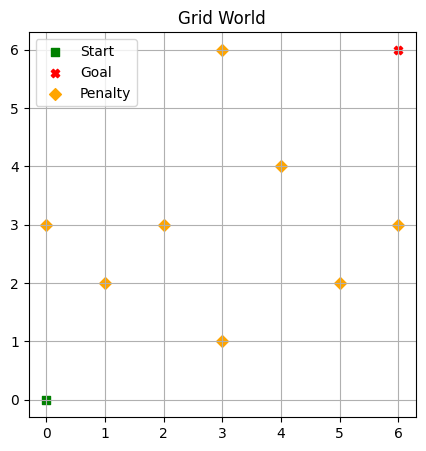

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(0, 0, c='green', marker='s', label='Start')
plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
for i, (px, py) in enumerate(PENALTIES):
    if i == 0:
        plt.scatter(px, py, c='orange', marker='D', label='Penalty')
    else:
        plt.scatter(px, py, c='orange', marker='D')
plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Grid World")
plt.legend()
plt.grid(True)
plt.show()

# REINFORCE Algorithm (30 Points)

The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

### Policy Network Definition (10 points)

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        return torch.log_softmax(self.fc2(x), dim=-1)


### REINFORCE Agent Implementation (20 Points)

In [7]:
from tqdm import tqdm  # Ensure tqdm is imported

class ReinforceAgent:
    def __init__(self, lr=0.005, gamma=0.99):
        # The state is represented by an (x, y) coordinate, so input dimension is 2.
        self.input_dim = 2    
        # There are as many outputs as the number of actions.
        self.output_dim = len(ACTIONS)  
        # Hidden dimension can be tuned; here we choose 128.
        self.hidden_dim = 128   
        self.policy_net = PolicyNetwork(self.input_dim, self.output_dim, self.hidden_dim).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
    
    def train(self, episodes=6000, epsilon=1.0, epsilon_decay=0.9995, min_epsilon=0.01, max_steps=150):
        # Lists to record loss and rewards per episode
        loss_list = []
        reward_list = []
        
        # Use tqdm for a progress bar over episodes
        pbar = tqdm(range(episodes), desc="Training Reinforce Agent")
        
        for episode in pbar:
            state = (0, 0)
            trajectory, rewards = [], []
            steps = 0
            
            # Limit steps per episode to prevent infinite loops.
            while state != GOAL and steps < max_steps:
                state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                # Convert tensor output to numpy array safely (move to CPU first)
                log_action_probs = self.policy_net(state_tensor).detach().cpu().numpy()
                action_probs = np.exp(log_action_probs)
                
                random_value = random.random()  # Generate a random number between 0 and 1.

                # Epsilon-greedy action selection:
                if random_value < epsilon:
                    action = random.choice(ACTIONS)
                else:
                    best_action_index = np.argmax(action_probs)
                    action = ACTIONS[best_action_index]

                # Take a step in the Grid World based on the chosen action.
                next_state, reward = grid_world.step(state, action)

                # Record the transition and reward.
                trajectory.append((state, action, reward))
                rewards.append(reward)

                state = next_state
                steps += 1

            # Compute discounted returns.
            returns, G = [], 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            
            returns = torch.tensor(returns, dtype=torch.float32).to(device)
            baseline = returns.mean()
            returns -= baseline
            
            loss = 0
            # Compute the policy gradient loss.
            for (state, action, _), G in zip(trajectory, returns):
                state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                log_action_probs = self.policy_net(state_tensor)
                loss -= log_action_probs[ACTION_IDX[action]] * G
            
            # Record loss and total reward.
            loss_list.append(loss.item())
            total_reward = sum(rewards)
            reward_list.append(total_reward)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
            
            # Update tqdm progress bar with training details.
            pbar.set_postfix({
                "Episode": episode,
                "Reward": total_reward,
                "Loss": round(loss.item(), 4),
                "Epsilon": round(epsilon, 4)
            })
        
        # Return recorded loss and rewards for plotting later.
        return loss_list, reward_list

    def get_optimal_trajectory(self, max_steps=150):
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        steps = 0
        while state != GOAL and steps < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            log_action_probs = self.policy_net(state_tensor).detach().cpu().numpy()  # Ensure .cpu() is used
            action_probs = np.exp(log_action_probs)
            action = np.random.choice(ACTIONS, p=action_probs / action_probs.sum())
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
            steps += 1
        return trajectory, rewards


# Genetic Algorithm


Genetic Algorithms (GAs) are optimization algorithms inspired by **natural selection**. They evolve a population of candidate solutions over multiple generations to find an optimal or near-optimal solution.

#### **1. Population ($P$)**
A **population** consists of multiple candidate solutions (individuals). Each individual represents a **policy or solution** encoded as a chromosome.

$$[
P_t = \{ X_1^t, X_2^t, ..., X_N^t \}
]$$

where:
- $( P_t )$ is the population at generation $( t )$,
- $( X_i^t )$ is the $( i )$-th individual in the population,
- $( N )$ is the population size.

#### **2. Fitness Function ($F$)**
Each individual is evaluated using a **fitness function**, which measures how good a solution is.

$$[
F(X_i) = \text{reward or performance score of } X_i
]$$

#### **3. Selection**
The best individuals are selected based on their fitness scores to produce the next generation. Common methods include:
- **Roulette Wheel Selection** (Probability proportional to fitness)
- **Tournament Selection** (Select the best out of a subset)

#### **4. Crossover (Recombination)**
Two parents **combine genetic information** to create offspring. A common method is **single-point crossover**, where a random crossover point is chosen.

$$
\begin{aligned}
\text{Parent 1} &= (A_1, A_2, | A_3, A_4, A_5) \\
\text{Parent 2} &= (B_1, B_2, | B_3, B_4, B_5) \\
\text{Offspring 1} &= (A_1, A_2, | B_3, B_4, B_5) \\
\text{Offspring 2} &= (B_1, B_2, | A_3, A_4, A_5)
\end{aligned}
$$

#### **5. Mutation**
Mutation introduces small **random changes** in individuals to maintain diversity and avoid local optima. If $( X_i )$ is an individual, a mutation function $( M )$ alters some genes:

$$[
X_i' = M(X_i)
]$$

For example, if an individual’s policy is `['up', 'right', 'down']`, mutation might randomly change `right` to `left`.

#### **6. Generations & Evolution**
The new population is formed after selection, crossover, and mutation. The process repeats for **multiple generations** until a stopping criterion is met (e.g., max generations or convergence).

$$[
P_{t+1} = \text{next\_generation}(P_t)
]$$



### Genetic Algorithm Implementation

In [8]:
from tqdm import tqdm
import numpy as np

class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, policy_network, generations=100, device='cpu'):
        self.device = device
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.policy_network = policy_network.to(self.device)  # Move the model to GPU if available
        self.population = [self._initialize_individual() for _ in range(population_size)]

    def _initialize_individual(self):
        # Initialize an individual by setting random weights for the policy network
        individual = {}
        for name, param in self.policy_network.named_parameters():
            individual[name] = torch.randn_like(param).to(self.device)  # Initialize random weights on the device
        return individual

    def _evaluate_individual(self, individual, max_steps=150):
        # Evaluate the individual by applying its weights to the policy network and running a simulation
        self._apply_individual_weights(individual)
        state = (0, 0)
        STOP = 0
        trajectory, rewards = [], []
        while state != GOAL and STOP < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()  # Choose the action with the highest probability
            action = ACTIONS[action_idx]
            new_state, reward = grid_world.step(state, action)
            trajectory.append((state, action, reward))
            rewards.append(reward)
            state = new_state
            STOP += 1
        return sum(rewards)

    def _apply_individual_weights(self, individual):
        # Apply the individual's weights to the policy network
        for name, param in individual.items():
            self.policy_network.state_dict()[name].copy_(param)

    def _select_parents(self):
        # Evaluate all individuals and select the two best based on fitness (reward sum)
        scores = [(ind, self._evaluate_individual(ind)) for ind in self.population]
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        parent1 = sorted_scores[0][0]
        parent2 = sorted_scores[1][0]
        return parent1, parent2

    def _crossover(self, parent1, parent2):
        # Create a child by combining the weights of two parents using a simple crossover strategy
        child = {}
        for name in parent1.keys():
            if random.random() < self.crossover_rate:
                child[name] = parent1[name]
            else:
                child[name] = parent2[name]
        return child

    def _mutate(self, individual):
        # Randomly mutate individual weights based on the mutation rate
        for name, param in individual.items():
            if random.random() < self.mutation_rate:
                individual[name] = torch.randn_like(param).to(self.device)  # Replace with new random weights
        return individual

    def run(self):
        # Lists to record generation statistics for future plotting.
        best_fitness_list = []
        avg_fitness_list = []
        pbar = tqdm(range(self.generations), desc="Running Genetic Algorithm")
        
        for generation in pbar:
            # Evaluate the entire population for the current generation.
            generation_scores = [self._evaluate_individual(ind) for ind in self.population]
            best_fitness = max(generation_scores)
            avg_fitness = np.mean(generation_scores)
            
            best_fitness_list.append(best_fitness)
            avg_fitness_list.append(avg_fitness)
            
            # Create a new population.
            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self._select_parents()
                child1 = self._crossover(parent1, parent2)
                child2 = self._crossover(parent2, parent1)
                new_population.append(self._mutate(child1))
                new_population.append(self._mutate(child2))
            self.population = new_population
            
            pbar.set_postfix({
                "Generation": generation + 1,
                "Best Fitness": best_fitness,
                "Avg Fitness": round(avg_fitness, 2)
            })
        
        # Return generation statistics for later analysis and plotting.
        return best_fitness_list, avg_fitness_list

    def get_optimal_trajectory(self, max_steps=150):
        # Using the best individual from the final population, derive the optimal trajectory from start to goal.
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        STOP = 0
        while state != GOAL and STOP < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()
            action = ACTIONS[action_idx]
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
            STOP += 1
        return trajectory, rewards


# Running & Comparing Agents (20 Points)

Training Reinforce Agent: 100%|██████████| 8000/8000 [08:20<00:00, 15.97it/s, Episode=7999, Reward=78, Loss=0, Epsilon=0.0183]


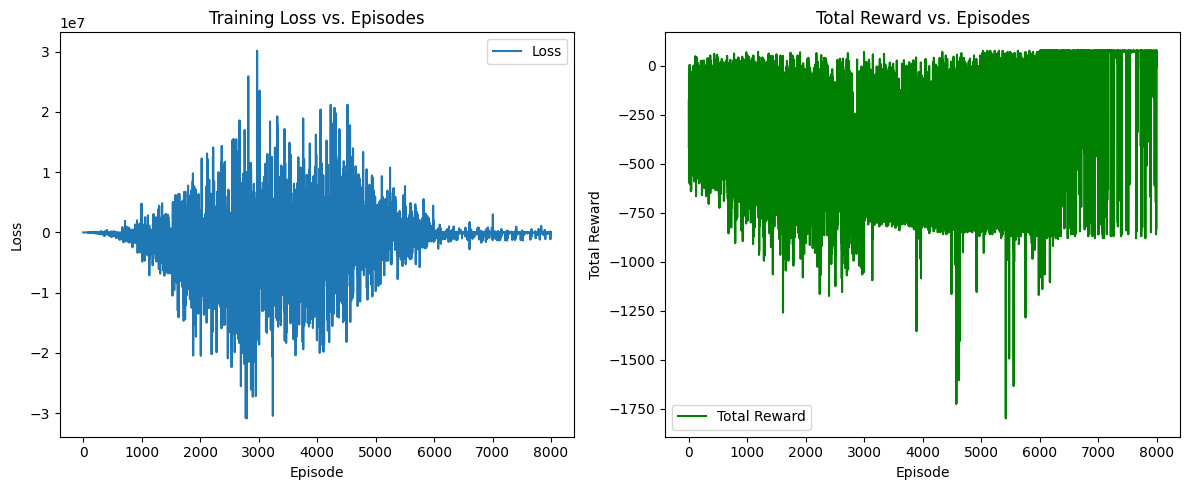

In [9]:
LEARNING_RATE = 0.005  # You can experiment with this value
GAMMA = 0.99         # Discount factor for future rewards

# Initialize and train the REINFORCE agent.
reinforce_agent = ReinforceAgent(lr=LEARNING_RATE, gamma=GAMMA)
loss_list, reward_list = reinforce_agent.train(
    episodes=8000, 
    epsilon=1.0, 
    epsilon_decay=0.9995, 
    min_epsilon=0.01
)

# Plot the training loss and rewards.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list, label="Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Training Loss vs. Episodes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(reward_list, label="Total Reward", color="green")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs. Episodes")
plt.legend()

plt.tight_layout()
plt.show()



Running Genetic Algorithm: 100%|██████████| 50/50 [14:45<00:00, 17.70s/it, Generation=50, Best Fitness=78, Avg Fitness=-150]


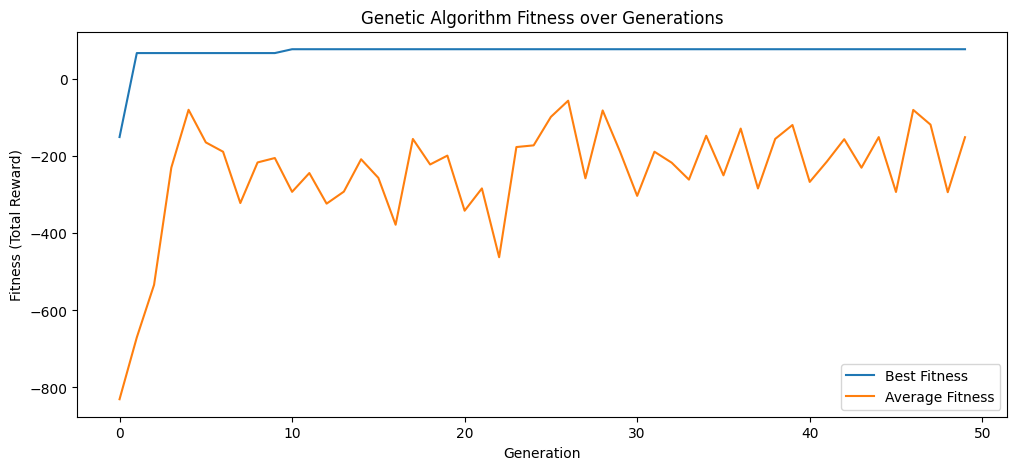

In [10]:
# Define Genetic Algorithm hyperparameters
POPULATION_SIZE = 50   # Number of individuals in the population
GENERATIONS = 50      # Number of generations to evolve
MUTATION_RATE = 0.1    # Probability of mutating an individual's weight
CROSSOVER_RATE = 0.5   # Probability to choose parent's weight during crossover

# Initialize the policy network with appropriate dimensions:
# State is represented by 2 coordinates, and there are len(ACTIONS) possible actions.
policy_network = PolicyNetwork(input_dim=2, output_dim=len(ACTIONS), hidden_dim=128)

# Create the Genetic Algorithm agent using the policy network and hyperparameters.
genetic_agent = GeneticAlgorithm(
    generations=GENERATIONS,
    population_size=POPULATION_SIZE,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSSOVER_RATE,
    policy_network=policy_network,
    device=device
)

# Run the Genetic Algorithm evolution process and capture training statistics.
best_fitness_list, avg_fitness_list = genetic_agent.run()

# Plot the training fitness values over generations.
plt.figure(figsize=(12, 5))
plt.plot(best_fitness_list, label="Best Fitness")
plt.plot(avg_fitness_list, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness (Total Reward)")
plt.title("Genetic Algorithm Fitness over Generations")
plt.legend()
plt.show()


# Visualizing Results (40 Points)

Plots the agent’s trajectory in the Grid World.

In [11]:
def visualize_trajectory(trajectory, title):
    plt.figure(figsize=(5, 5))
    x_vals, y_vals = zip(*trajectory)
    plt.plot(x_vals, y_vals, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.scatter(0, 0, c='green', marker='s', label='Start')
    plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
    for i, (px, py) in enumerate(PENALTIES):
        if i == 0:
            plt.scatter(px, py, c='orange', marker='D', label='Penalty')
        else:
            plt.scatter(px, py, c='orange', marker='D')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Results

Standard Environment - REINFORCE Agent
Final Reward (REINFORCE): 78


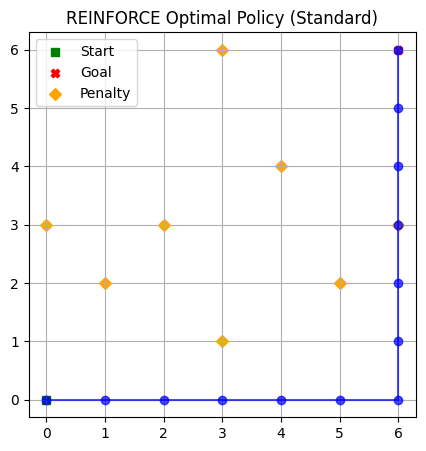


--------------------------------------------------------------------------------------

Standard Environment - Genetic Algorithm Agent
Final Reward (Genetic Algorithm): 78


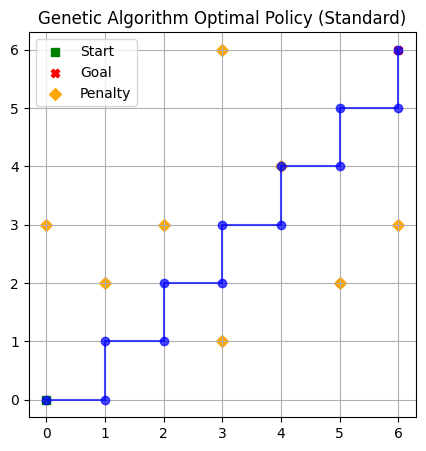

In [12]:
print("Standard Environment - REINFORCE Agent")
optimal_reinforce_trajectory, final_reward_reinforce = reinforce_agent.get_optimal_trajectory()
print(f"Final Reward (REINFORCE): {final_reward_reinforce}")
visualize_trajectory(optimal_reinforce_trajectory, "REINFORCE Optimal Policy (Standard)")

print("\n--------------------------------------------------------------------------------------\n")

print("Standard Environment - Genetic Algorithm Agent")
optimal_genetic_trajectory, final_reward_genetic = genetic_agent.get_optimal_trajectory()
print(f"Final Reward (Genetic Algorithm): {final_reward_genetic}")
visualize_trajectory(optimal_genetic_trajectory, "Genetic Algorithm Optimal Policy (Standard)")

$\bullet$ Based on the implementation and results from comparing policy search using Genetic Algorithm (GA) and the REINFORCE algorithm:

**Question 1:** (10 points)

How do these two methods differ in terms of their effectiveness for solving reinforcement learning tasks?   **ANSWER IN THE REPORT**

**Question 2:** (15 points)

Discuss the key differences in their **performance**, **convergence rates**, and **stability**.   **ANSWER IN THE REPORT**

**Question 3:** (15 points)

Additionally, explore how each method handles exploration and exploitation, and suggest situations where one might be preferred over the other.  **ANSWER IN THE REPORT**


az inja be bad khodam ezafe kardam

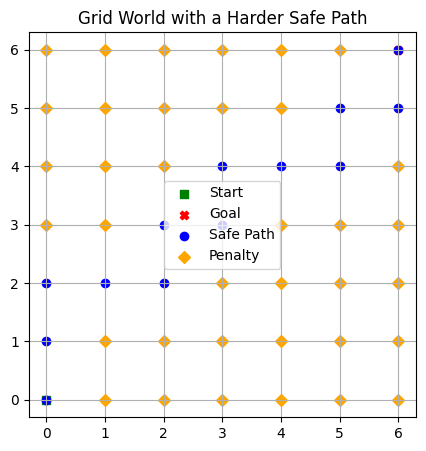

In [13]:
# Grid World Parameters
GRID_SIZE = 7

# Define a more challenging (non-linear) safe path.
# This safe path is manually defined and meanders through the grid.
SAFE_PATH = [
    (0, 0),
    (0, 1),
    (0, 2),
    (1, 2),
    (2, 2),
    (2, 3),
    (3, 3),
    (3, 4),
    (4, 4),
    (5, 4),
    (5, 5),
    (6, 5),
    (6, 6)
]

# Specify the goal location.
GOAL = (6, 6)

# Assign reward values.
GOAL_REWARD = 500
STEP_PENALTY = -1
BOUNDARY_PENALTY = -5

# Define a heavy penalty for cells that are not on the safe path.
DEFAULT_PENALTY = -10

# Build the PENALTIES dictionary: every cell not on the safe path gets a penalty.
PENALTIES = {}
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        if (i, j) not in SAFE_PATH:
            PENALTIES[(i, j)] = DEFAULT_PENALTY

ACTIONS = ['up', 'down', 'left', 'right']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

class GridWorld:
    def step(self, state, action):
        x, y = state
        new_x, new_y = x, y
        
        if action == 'right':
            new_x = min(x + 1, GRID_SIZE - 1)
        elif action == 'left':
            new_x = max(x - 1, 0)
        elif action == 'up':
            new_y = min(y + 1, GRID_SIZE - 1)
        elif action == 'down':
            new_y = max(y - 1, 0)
        
        reward = STEP_PENALTY
        
        # If the action results in no change, we've hit a boundary.
        if (new_x, new_y) == (x, y):
            reward += BOUNDARY_PENALTY
        
        # Apply penalty if the new cell is designated as a penalty cell.
        if (new_x, new_y) in PENALTIES:
            reward += PENALTIES[(new_x, new_y)]
        
        # Apply goal reward if reached.
        if (new_x, new_y) == GOAL:
            reward += GOAL_REWARD

        return (new_x, new_y), reward

# Instantiate the environment.
grid_world = GridWorld()

# Visualization of the Grid World environment.
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
# Plot the start (green square) and goal (red X).
plt.scatter(0, 0, c='green', marker='s', label='Start')
plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')

# Plot the safe path in blue.
for idx, cell in enumerate(SAFE_PATH):
    plt.scatter(cell[0], cell[1], c='blue', marker='o', label='Safe Path' if idx == 0 else "")

# Plot the penalty cells in orange.
for idx, cell in enumerate(PENALTIES.keys()):
    plt.scatter(cell[0], cell[1], c='orange', marker='D', label='Penalty' if idx == 0 else "")

plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Grid World with a Harder Safe Path")
plt.legend()
plt.grid(True)
plt.show()


Training Reinforce Agent: 100%|██████████| 8000/8000 [14:25<00:00,  9.24it/s, Episode=7999, Reward=-920, Loss=5.26e+5, Epsilon=0.0183]


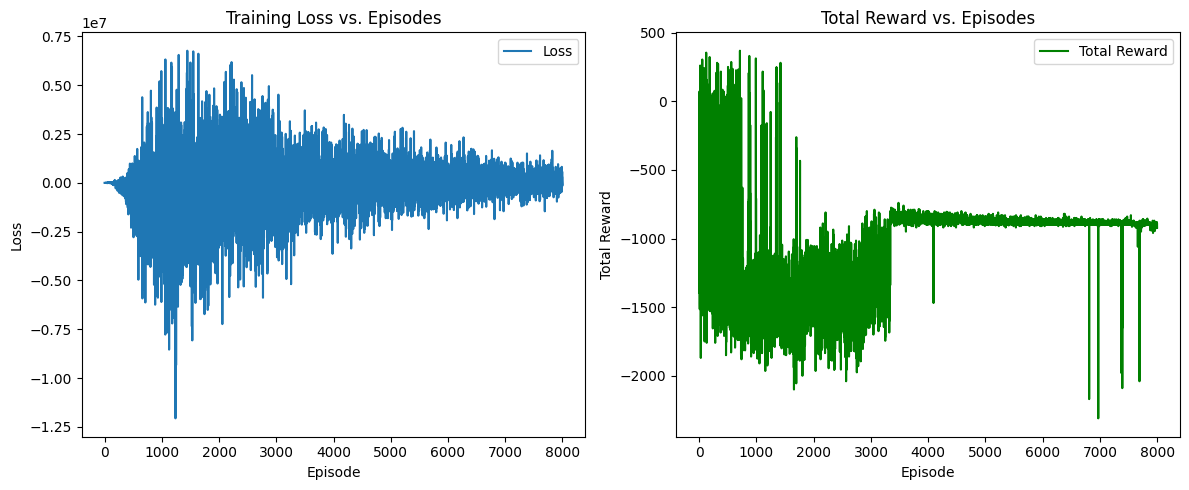

In [14]:
LEARNING_RATE = 0.005  # You can experiment with this value
GAMMA = 0.99         # Discount factor for future rewards

# Initialize and train the REINFORCE agent.
reinforce_agent = ReinforceAgent(lr=LEARNING_RATE, gamma=GAMMA)
loss_list, reward_list = reinforce_agent.train(
    episodes=8000, 
    epsilon=1.0, 
    epsilon_decay=0.9995, 
    min_epsilon=0.01
)

# Plot the training loss and rewards.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list, label="Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Training Loss vs. Episodes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(reward_list, label="Total Reward", color="green")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs. Episodes")
plt.legend()

plt.tight_layout()
plt.show()



Running Genetic Algorithm: 100%|██████████| 50/50 [16:38<00:00, 19.97s/it, Generation=50, Best Fitness=488, Avg Fitness=11.7]


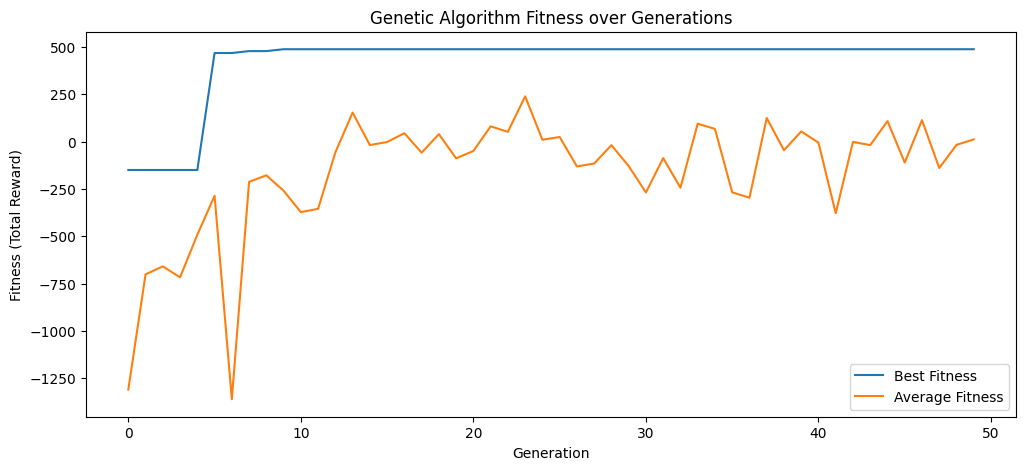

In [15]:
# Define Genetic Algorithm hyperparameters
POPULATION_SIZE = 50   # Number of individuals in the population
GENERATIONS = 50     # Number of generations to evolve
MUTATION_RATE = 0.1    # Probability of mutating an individual's weight
CROSSOVER_RATE = 0.5   # Probability to choose parent's weight during crossover

# Initialize the policy network with appropriate dimensions:
# State is represented by 2 coordinates, and there are len(ACTIONS) possible actions.
policy_network = PolicyNetwork(input_dim=2, output_dim=len(ACTIONS), hidden_dim=128)

# Create the Genetic Algorithm agent using the policy network and hyperparameters.
genetic_agent = GeneticAlgorithm(
    generations=GENERATIONS,
    population_size=POPULATION_SIZE,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSSOVER_RATE,
    policy_network=policy_network,
    device=device
)

# Run the Genetic Algorithm evolution process and capture training statistics.
best_fitness_list, avg_fitness_list = genetic_agent.run()

# Plot the training fitness values over generations.
plt.figure(figsize=(12, 5))
plt.plot(best_fitness_list, label="Best Fitness")
plt.plot(avg_fitness_list, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness (Total Reward)")
plt.title("Genetic Algorithm Fitness over Generations")
plt.legend()
plt.show()


HARD Environment - REINFORCE Agent
Final Reward (REINFORCE): -900


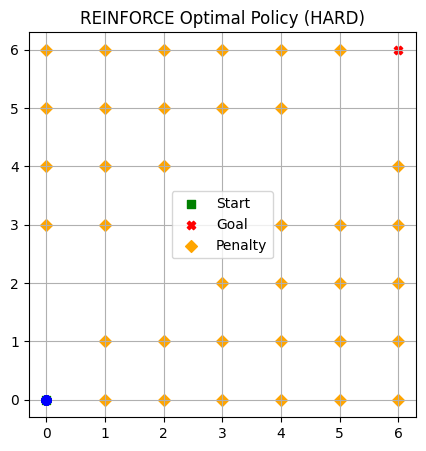


--------------------------------------------------------------------------------------

HARD Environment - Genetic Algorithm Agent
Final Reward (Genetic Algorithm): -900


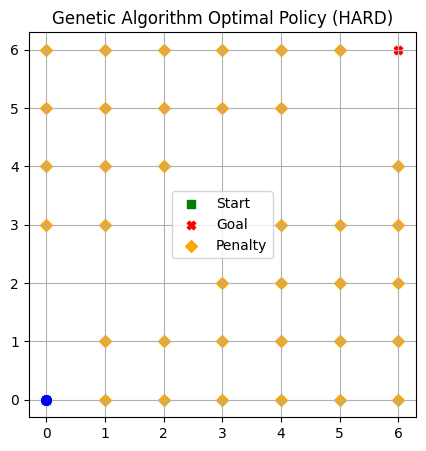

In [16]:
print("HARD Environment - REINFORCE Agent")
optimal_reinforce_trajectory, final_reward_reinforce = reinforce_agent.get_optimal_trajectory()
print(f"Final Reward (REINFORCE): {final_reward_reinforce}")
visualize_trajectory(optimal_reinforce_trajectory, "REINFORCE Optimal Policy (HARD)")

print("\n--------------------------------------------------------------------------------------\n")

print("HARD Environment - Genetic Algorithm Agent")
optimal_genetic_trajectory, final_reward_genetic = genetic_agent.get_optimal_trajectory()
print(f"Final Reward (Genetic Algorithm): {final_reward_genetic}")
visualize_trajectory(optimal_genetic_trajectory, "Genetic Algorithm Optimal Policy (HARD)")